## Introduction
### Problem Statement:-

Brain tumor segmentation on MRI scans is a key step in the diagnosis, treatment planning, and ongoing management of brain cancer. Regardless of the improvement in deep learning, several difficulties persist in achieving the wholesome, great, and clinically applicable segmentation models. Traditional CNN-based methods often struggle to capture long-range dependencies within volumetric MRI data, limiting their ability to delineate complex tumor structures. While Transformer-based models have improved global contextual understanding, they frequently require large computational resources and struggle to generalize across datasets due to variations in imaging protocols and tumor morphology.
Additionally, many existing models either emphasize accuracy at the expense of speed and resource efficiency or prioritize lightweight design at the cost of segmentation performance. In real-world clinical settings, this exchange can be detrimental. Therefore, there is a pressing need for an optimized segmentation technique that balances high performance with computational efficiency and adaptability.
This research addresses the gap by investigating and implementing a hybrid, optimized segmentation framework that integrates the strengths of CNNs and Transformers. The goal is to enhance brain tumor diagnosis by improving accuracy, reducing inference time, and maintaining robustness across multiple datasets.


### solution:-

This notebook tackles the task of semantic segmentation that classifying each pixel in an MRI image as tumor or nontumor using the U-Net architecture, which is well-suited for biomedical image segmentation.

### Dataset Overview:-

Dataset link:-https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation/data

->Images – MRI scans of brain (3024 images-gray scale values)

->Masks – Binary masks where tumor regions are marked in white (pixel value 1), and non-tumor regions are black (pixel value 0)

->Each image and mask pair has the same filename, making it easy to match them for supervised learning.

### Research Objectives:-

->To identify and analyze benchmarking datasets on brain tumor segmentation.

->To design and implement an optimized deep learning model that merges the potential of CNNs and Transformers to enhance 3D brain tumor segmentation.

->To assess the model’s performance based on key metrics such as Dice coefficient, sensitivity, specificity, and inference time.

->To explore the generalizability and computational efficiency of the optimized model for clinical applicability.




## Import libraries


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import normalize
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
#learning rate scheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau


## Data preprocessing

Add this data set before run the below command:-

https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation


In [ ]:
import kagglehub
from pathlib import Path

# Download latest version of LGG MRI dataset
base = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")
print("Path to dataset files:", base)

# Set base path
# base = Path.home() / "Desktop" / "MRI Data"
img_dir = Path(base) / "images"
msk_dir = Path(base) / "masks"

# Get sorted lists of files (assuming names match, e.g., image_0.png <-> mask_0.png)
img_files = sorted(list(img_dir.glob("*.png")))
msk_files = sorted(list(msk_dir.glob("*.png")))

print("Number of images:", len(img_files))
print("Number of masks:", len(msk_files))

Path to dataset files: /kaggle/input/brain-tumor-segmentation
Number of images: 3064
Number of masks: 3064


In [ ]:
# Fixed image size
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Initialize lists to store image and mask data
images = []
masks = []


In [ ]:
for img_name, mask_name in zip(img_files, msk_files):
# Read image and mask in grayscale
    img = cv2.imread(os.path.join(img_dir, img_name), cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(os.path.join(msk_dir, mask_name), cv2.IMREAD_GRAYSCALE)

# Resize both to 512x512 which is input to the unet
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))

# Append to lists
    images.append(img)
    masks.append(mask)

In [ ]:
# Convert to NumPy arrays
images = np.array(images)
masks = np.array(masks)

In [ ]:
# Normalize images to range [0, 1]
images = images / 255.0
# Normalize to [0, 1] and binarize
masks = masks / 255.0
masks = (masks > 0.5).astype(np.float32)


### sample image and mask

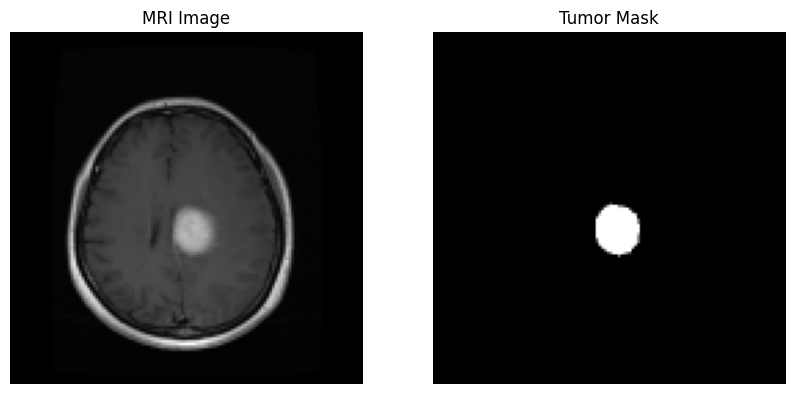

In [ ]:
# Load the first image and its mask in grayscale
sample_img = images[1]
sample_mask = masks[1]

# Resize both to 128x128 for quick visualizationx
sample_img = cv2.resize(sample_img, (128, 128))
sample_mask = cv2.resize(sample_mask, (128, 128))

# Plot side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("MRI Image")
plt.imshow(sample_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Tumor Mask")
plt.imshow(sample_mask, cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
# Reshape to add channel dimension (needed for U-Net input)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
masks = masks.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)

print("Image shape:", images.shape)
print("Mask shape:", masks.shape)

Image shape: (3064, 256, 256, 1)
Mask shape: (3064, 256, 256, 1)


In [ ]:
import random

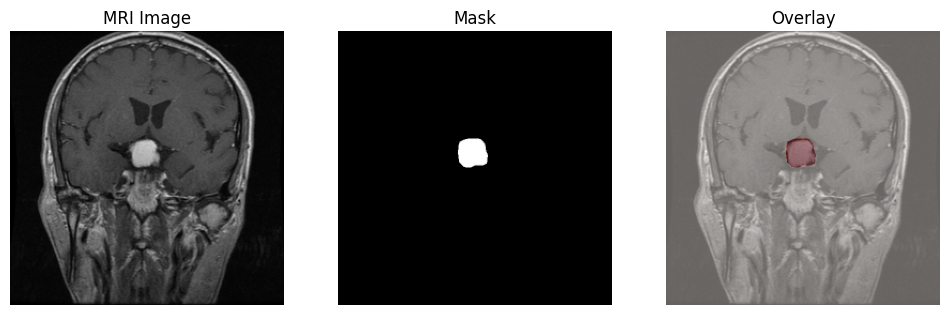

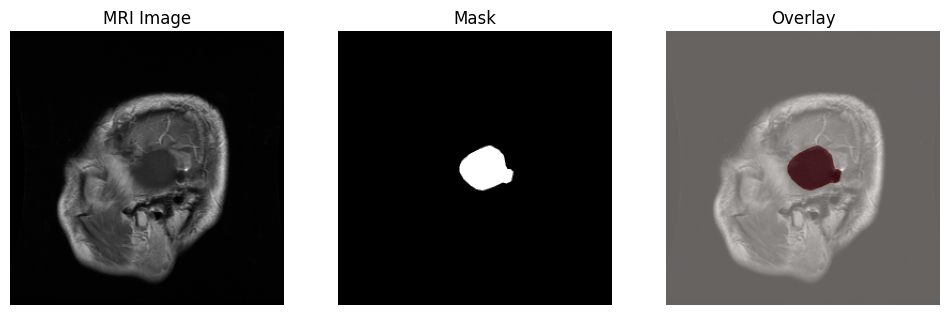

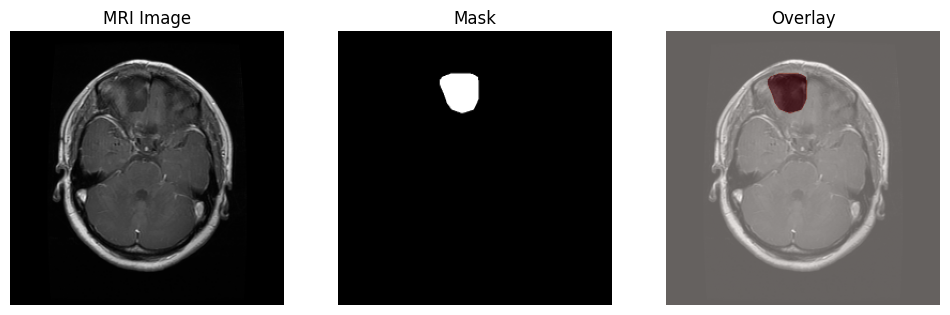

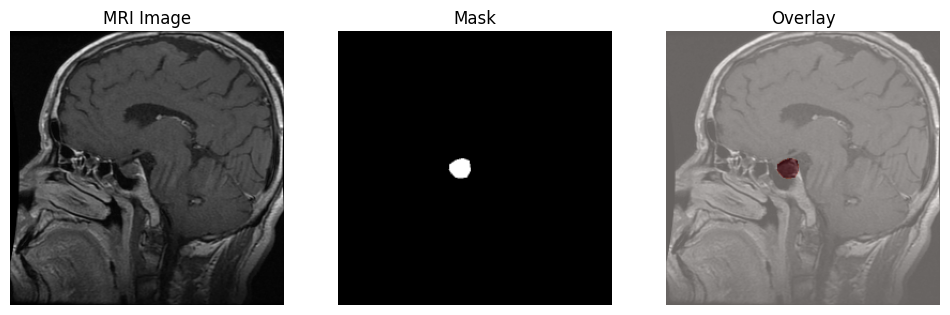

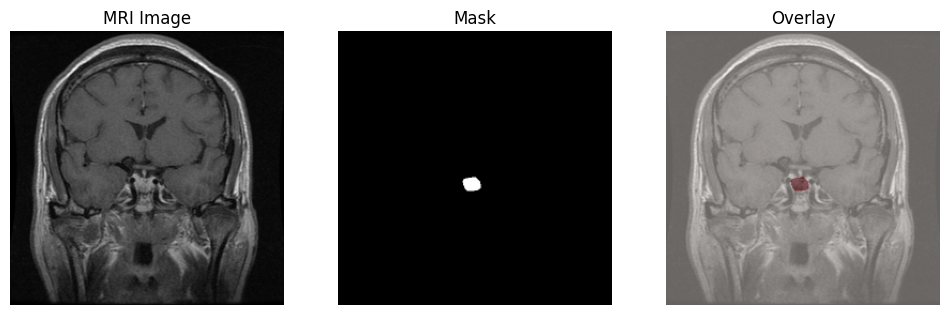

In [ ]:
def show_random_pairs(n=5):
    # Get random indices
    indices = random.sample(range(len(img_files)), n)

    for i in indices:
        # Read image and mask using the file paths
        img = cv2.imread(str(img_files[i]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(str(msk_files[i]), cv2.IMREAD_GRAYSCALE)

        # Resize both for consistent plotting
        img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        mask_resized = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img_resized, cmap="gray")
        plt.title("MRI Image")
        plt.axis("off")

        plt.subplot(1,3,2)
        plt.imshow(mask_resized, cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(1,3,3)
        plt.imshow(img_resized, cmap="gray")
        # Overlay the mask, ensuring it's in the correct range for alpha blending
        plt.imshow(mask_resized, cmap="Reds", alpha=0.4)
        plt.title("Overlay")
        plt.axis("off")

        plt.show()

show_random_pairs(5)

Images shape: (3064, 256, 256, 1)
Masks shape: (3064, 256, 256, 1)
Images dtype: float64
Masks dtype: float32
Images min pixel value: 0.0
Images max pixel value: 1.0
Unique mask values: [0. 1.]
Mask value counts: [197357209   3445095]


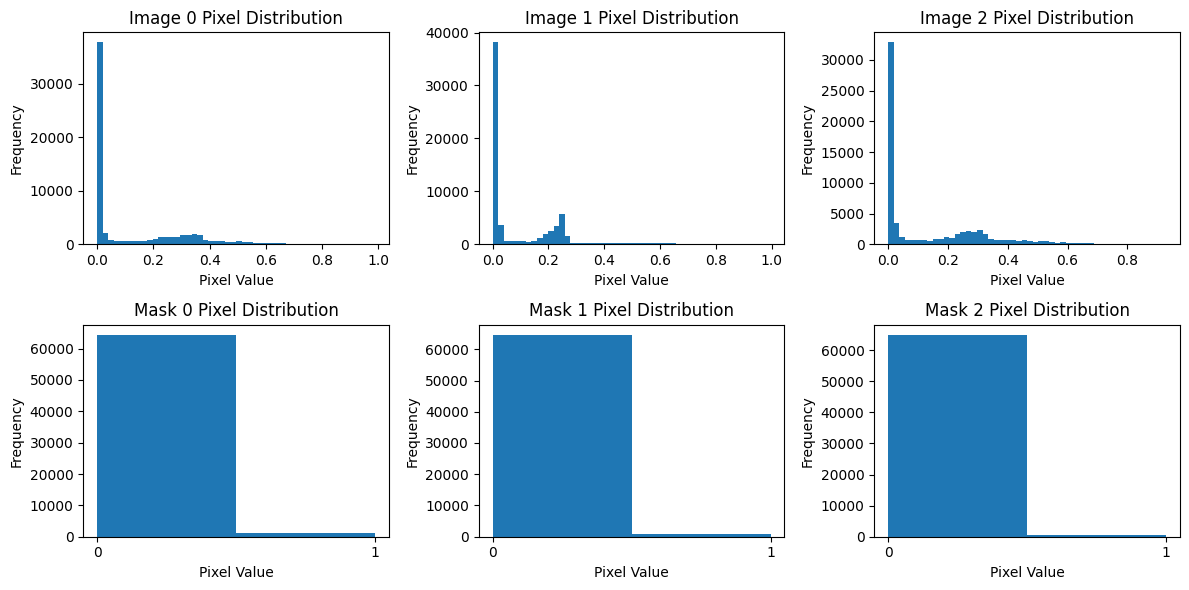

In [ ]:
# Check the shape and data type of the images and masks
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)
print("Images dtype:", images.dtype)
print("Masks dtype:", masks.dtype)

# Check the range of pixel values in images
print("Images min pixel value:", np.min(images))
print("Images max pixel value:", np.max(images))

# Check the unique values and their counts in masks (should be 0 and 1)
unique_mask_values, mask_counts = np.unique(masks, return_counts=True)
print("Unique mask values:", unique_mask_values)
print("Mask value counts:", mask_counts)

# Visualize histograms of pixel values for a few sample images and masks
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.hist(images[i].flatten(), bins=50)
    plt.title(f"Image {i} Pixel Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(2, 3, i + 4)
    plt.hist(masks[i].flatten(), bins=2)
    plt.title(f"Mask {i} Pixel Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.xticks([0, 1])

plt.tight_layout()
plt.show()

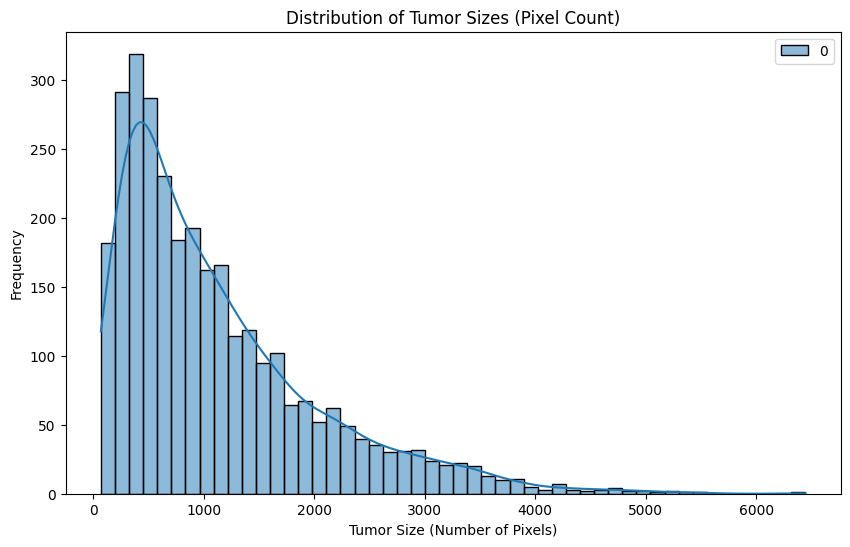


Tumor Size Descriptive Statistics:
Mean: 1124.38
Median: 856.00
Standard Deviation: 910.64
Min: 70.00
Max: 6446.00


In [ ]:
import seaborn as sns
# Calculate the total number of pixels in each mask that are part of the tumor (value = 1)
tumor_sizes = np.sum(masks, axis=(1, 2))

# Visualize the distribution of tumor sizes
plt.figure(figsize=(10, 6))
sns.histplot(tumor_sizes, bins=50, kde=True)
plt.title("Distribution of Tumor Sizes (Pixel Count)")
plt.xlabel("Tumor Size (Number of Pixels)")
plt.ylabel("Frequency")
plt.show()

# Calculate and print some descriptive statistics for tumor sizes
print("\nTumor Size Descriptive Statistics:")
print(f"Mean: {np.mean(tumor_sizes):.2f}")
print(f"Median: {np.median(tumor_sizes):.2f}")
print(f"Standard Deviation: {np.std(tumor_sizes):.2f}")
print(f"Min: {np.min(tumor_sizes):.2f}")
print(f"Max: {np.max(tumor_sizes):.2f}")

### train_test_split

In [ ]:
# Step 1: Split into train and temp (temp will be split into val and test)
x_train, x_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)

# Step 2: Split temp into val and test
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.33, random_state=42)

print("Train:", x_train.shape, y_train.shape)
print("Val:  ", x_val.shape, y_val.shape)
print("Test: ", x_test.shape, y_test.shape)


Train: (2144, 256, 256, 1) (2144, 256, 256, 1)
Val:   (616, 256, 256, 1) (616, 256, 256, 1)
Test:  (304, 256, 256, 1) (304, 256, 256, 1)


## Define U-Net Model

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c6)


    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32 ,(3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same', kernel_initializer = 'he_normal')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer = 'he_normal')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Define Dice Coefficient and Loss

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
model = unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 1))
model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_loss, metrics=[dice_coef])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 8,934,417 (34.08 MB)

 Trainable params: 8,934,417 (34.08 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [ ]:
history = model.fit(x_train,y_train,
                    validation_data=(x_val, y_val),
                    epochs=30,
                    )

Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - dice_coef: 0.0500 - loss: 0.9500 - val_dice_coef: 0.1014 - val_loss: 0.8985
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 100s 610ms/step - dice_coef: 0.0886 - loss: 0.9114 - val_dice_coef: 3.1097e-05 - val_loss: 1.0000
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 39s 582ms/step - dice_coef: 0.0073 - loss: 0.9927 - val_dice_coef: 0.0321 - val_loss: 0.9681
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 44s 621ms/step - dice_coef: 0.0325 - loss: 0.9675 - val_dice_coef: 0.0336 - val_loss: 0.9666
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 82s 624ms/step - dice_coef: 0.0333 - loss: 0.9667 - val_dice_coef: 0.0345 - val_loss: 0.9658
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 610ms/step - dice_coef: 0.0357 - loss: 0.9643 - val_dice_coef: 0.0438 - val_loss: 0.9565
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 626ms/step - dice_coef: 0.0453 - loss: 0.9547 - val_dice_coef: 0.0920 - val_loss: 0.9080
Epoch 8/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 83s 643ms/step - dice_coef: 0.1051 - loss:

In [ ]:
# Evaluate the model on the test set
test_results = model.evaluate(x_test, y_test)
# Store the evaluation results
test_loss = test_results[0]
test_dice_coef = test_results[1]
# Print the test loss and test dice coefficient
print(f"Test Loss: {test_loss}")
print(f"Test Dice Coefficient: {test_dice_coef}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - dice_coef: 0.5748 - loss: 0.4247
Test Loss: 0.44552522897720337
Test Dice Coefficient: 0.5515350103378296


## Testing

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step


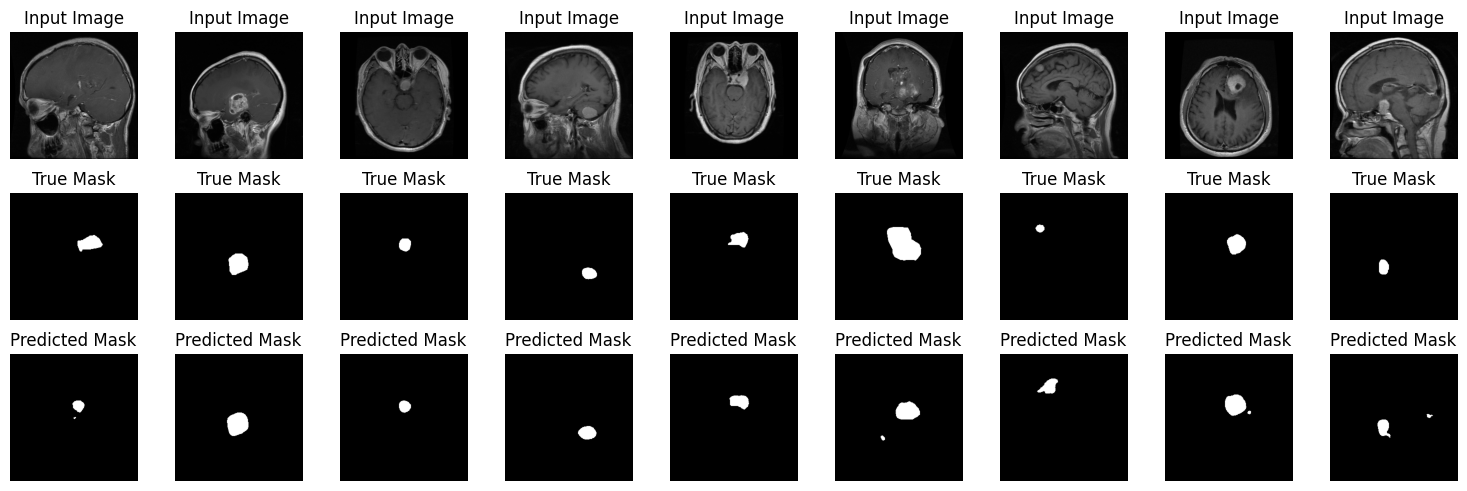

In [ ]:
import matplotlib.pyplot as plt


# Predict on test images
preds = model.predict(x_test)

# Binarize predictions
preds = (preds > 0.5).astype(np.float32)

# Show some results
n = 9  # number of samples to display
plt.figure(figsize=(15, 5))
for i in range(n):
    plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + n)
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

## plotting Dice coefficient and loss

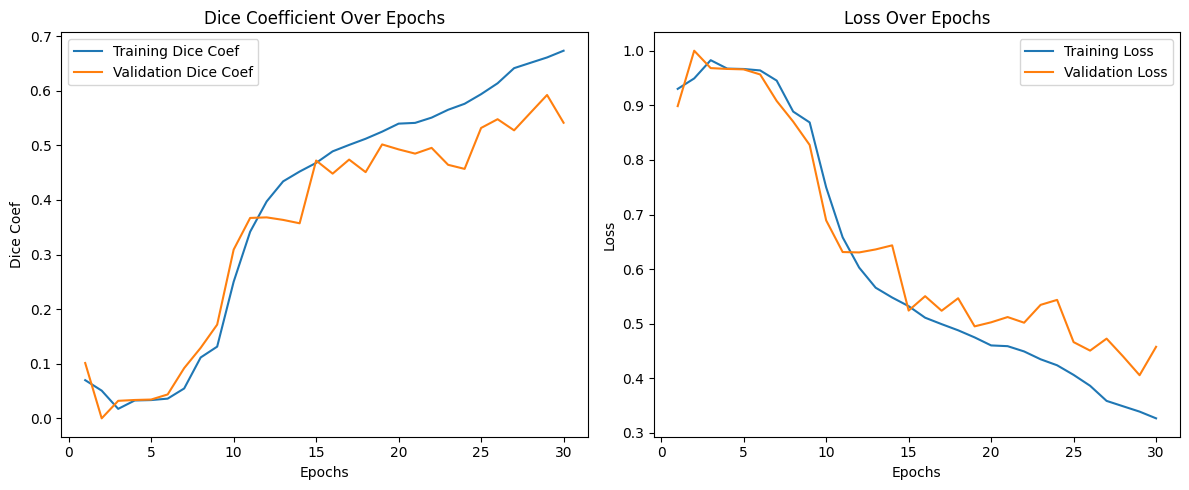

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics
dice = history.history['dice_coef']
val_dice = history.history['val_dice_coef']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot
epochs = range(1, len(dice) + 1)

plt.figure(figsize=(12, 5))

# Dice Coefficient
plt.subplot(1, 2, 1)
plt.plot(epochs, dice, label='Training Dice Coef')
plt.plot(epochs, val_dice, label='Validation Dice Coef')
plt.title('Dice Coefficient Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice Coef')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Prediction for a Specific Input

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


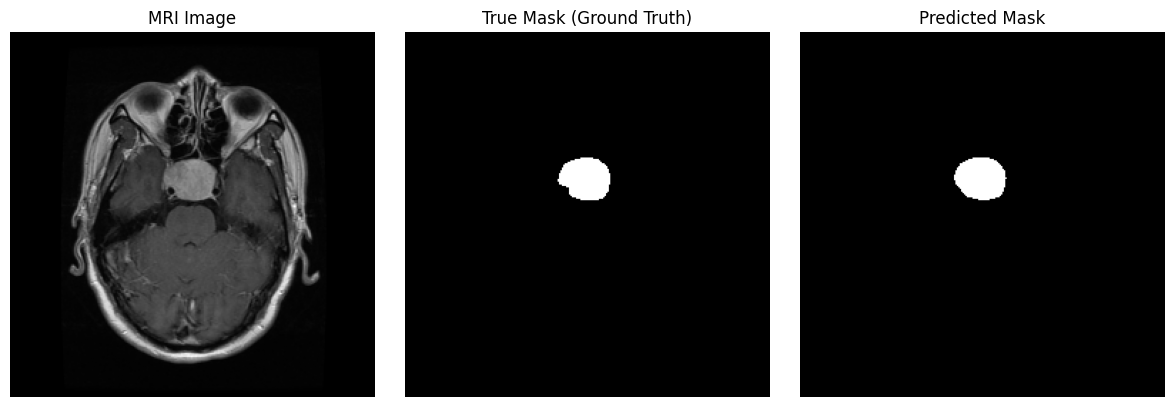

In [ ]:
i = 300  # any valid index from test set

# Get input image, true mask, predicted mask
image = x_test[i]
true_mask = y_test[i]
pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

# Binarize the prediction
pred_mask = (pred_mask > 0.5).astype(np.float32)

# Plot all three
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(image.squeeze(), cmap='gray')
plt.title("MRI Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("True Mask (Ground Truth)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred_mask.squeeze(), cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.tight_layout()
plt.show()

Confusion matrix:
 [[19462250   115400]
 [  166549   178745]]
Dice: 0.5591 | Sensitivity (TPR): 0.5177 | Specificity (TNR): 0.9941


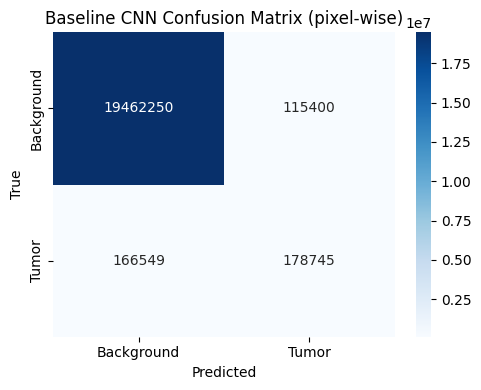

AUC: 0.9495


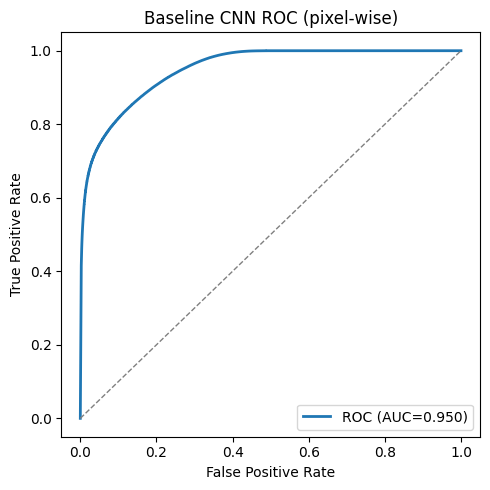

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

# ---- Predict on test set (keep probabilities for ROC) ----
pred_probs = model.predict(x_test, verbose=0)            # shape: (N, H, W, 1)
pred_bin   = (pred_probs > 0.5).astype(np.uint8)

# ---- Flatten to pixel vectors for per-pixel metrics ----
y_true = y_test.reshape(-1).astype(np.uint8)
y_prob = pred_probs.reshape(-1)
y_pred = pred_bin.reshape(-1)

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
tn, fp, fn, tp = cm.ravel()
print("Confusion matrix:\n", cm)
sensitivity = tp / (tp + fn + 1e-7)   # recall / TPR
specificity = tn / (tn + fp + 1e-7)   # TNR
dice = (2*tp) / (2*tp + fp + fn + 1e-7)

print(f"Dice: {dice:.4f} | Sensitivity (TPR): {sensitivity:.4f} | Specificity (TNR): {specificity:.4f}")

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Background","Tumor"],
            yticklabels=["Background","Tumor"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Baseline CNN Confusion Matrix (pixel-wise)")
plt.tight_layout(); plt.show()

# ---- ROC & AUC (pixel-wise) ----
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', lw=1, color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Baseline CNN ROC (pixel-wise)")
plt.legend(loc="lower right")
plt.tight_layout(); plt.show()


### Hybrid CNN + Transformer (Keras, TransUNet-style)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, MaxPooling2D, Dropout,
                                     UpSampling2D, concatenate, LayerNormalization,
                                     Dense, Reshape, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

IMG_H, IMG_W = int(x_train.shape[1]), int(x_train.shape[2])

def DoubleConv(x, n_filters, dr=0.0):
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer = 'he_normal')(x)
    if dr>0: x = Dropout(dr)(x)
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer = 'he_normal')(x)
    return x

def transformer_block(x_tokens, num_heads=4, mlp_dim=256, drop_rate=0.1, name=None):
    # x_tokens: (B, N, C)
    shortcut = x_tokens
    x = LayerNormalization(name=None if name is None else name+"_ln1")(x_tokens)
    x = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1], dropout=drop_rate,
                                           name=None if name is None else name+"_mha")(x, x)
    x = Add()([shortcut, x])

    shortcut2 = x
    x = LayerNormalization(name=None if name is None else name+"_ln2")(x)
    x = Dense(mlp_dim, activation="gelu", name=None if name is None else name+"_mlp_fc1")(x)
    x = Dropout(drop_rate)(x)
    x = Dense(shortcut2.shape[-1], name=None if name is None else name+"_mlp_fc2")(x)
    x = Add()([shortcut2, x])
    return x

def HybridTransUNet(input_shape=(256,256,1),
                    base_filters=16,
                    patch_size=4,
                    embed_dim=256,
                    num_heads=4,
                    mlp_dim=512,
                    num_transformer_layers=4,
                    drop_rate=0.1):

    inp = Input(input_shape)

    # ------- Encoder (same style as your U-Net) -------
    c1 = DoubleConv(inp, base_filters, dr=0.1)                 # 256x256
    p1 = MaxPooling2D(2)(c1)                                   # 128x128

    c2 = DoubleConv(p1, base_filters*2, dr=0.1)                # 128x128
    p2 = MaxPooling2D(2)(c2)                                   # 64x64

    c3 = DoubleConv(p2, base_filters*4, dr=0.2)                # 64x64
    p3 = MaxPooling2D(2)(c3)                                   # 32x32

    c4 = DoubleConv(p3, base_filters*8, dr=0.2)                # 32x32
    p4 = MaxPooling2D(2)(c4)                                   # 16x16

    # ------- Bottleneck (CNN) -------
    c5 = DoubleConv(p4, base_filters*16, dr=0.3)               # 16x16, channels=base*16

    # ------- Patch Embedding on c4 or c5? -------
    # Using c4 (32x32) for more tokens while keeping cost low.
    # Create tokens by strided conv (kernel=stride=patch), then flatten to (B,N,embed_dim).
    # First, down-project c4 channels to embed_dim for the transformer.
    # Make sure (32 % patch_size == 0). With patch_size=4 -> 8x8 = 64 tokens.

    feat_for_tokens = c4
    patch_embed = Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size,
                         padding="valid", name="patch_embed")(feat_for_tokens)  # (B, 8, 8, embed_dim)

    Ht, Wt = patch_embed.shape[1], patch_embed.shape[2]        # 8, 8
    N = Ht * Wt                                                # sequence length
    tokens = Reshape((N, embed_dim), name="tokens")(patch_embed)

    # Positional embedding (trainable)
    # Use a Keras Layer for positional embedding
    class PositionalEmbedding(tf.keras.layers.Layer):
        def __init__(self, sequence_length, embed_dim, **kwargs):
            super().__init__(**kwargs)
            self.sequence_length = sequence_length
            self.embed_dim = embed_dim
            self.pos_emb = self.add_weight(
                name="pos_emb",
                shape=(1, sequence_length, embed_dim),
                initializer=tf.keras.initializers.RandomNormal(stddev=0.02),
                trainable=True,
            )

        def call(self, inputs):
            return inputs + self.pos_emb

    x_tok = PositionalEmbedding(sequence_length=N, embed_dim=embed_dim)(tokens)


    # ------- Transformer Encoder -------
    for i in range(num_transformer_layers):
        x_tok = transformer_block(x_tok, num_heads=num_heads, mlp_dim=mlp_dim, drop_rate=drop_rate,
                                  name=f"trans_block_{i+1}")

    # ------- Back to feature map ------
    x_feat = Reshape((Ht, Wt, embed_dim), name="tokens_to_map")(x_tok)  # (B,8,8,embed_dim)
    # Upsample transformer feature map back to 32x32 and fuse with c4
    x_feat = UpSampling2D(size=(patch_size, patch_size), interpolation="bilinear")(x_feat)  # (B,32,32,embed_dim)
    # Optionally compress to match decoder channels
    x_feat = Conv2D(base_filters*8, 1, padding="same", activation="relu", kernel_initializer="he_normal")(x_feat)
    fused = concatenate([x_feat, c4], name="fuse_transformer_skip")  # (B,32,32, base*8 + base*8)

    # ------- Decoder (U-Net style) -------
    u6 = Conv2DTranspose(base_filters*8, 2, strides=2, padding="same")(c5)  # up from 16->32 to meet fused
    u6 = concatenate([u6, fused])
    c6 = DoubleConv(u6, base_filters*8, dr=0.2)

    u7 = Conv2DTranspose(base_filters*4, 2, strides=2, padding="same")(c6)  # 32->64
    u7 = concatenate([u7, c3])
    c7 = DoubleConv(u7, base_filters*4, dr=0.2)

    u8 = Conv2DTranspose(base_filters*2, 2, strides=2, padding="same")(c7)  # 64->128
    u8 = concatenate([u8, c2])
    c8 = DoubleConv(u8, base_filters*2, dr=0.1)

    u9 = Conv2DTranspose(base_filters, 2, strides=2, padding="same")(c8)    # 128->256
    u9 = concatenate([u9, c1])
    c9 = DoubleConv(u9, base_filters, dr=0.1)

    out = Conv2D(1, 1, activation="sigmoid")(c9)
    return Model(inp, out, name="HybridTransUNet")

# ---- Build & compile the hybrid model ----
tf.keras.backend.clear_session()
hybrid = HybridTransUNet(input_shape=(IMG_H, IMG_W, 1),
                         base_filters=16,
                         patch_size=4,
                         embed_dim=256,
                         num_heads=4,
                         mlp_dim=512,
                         num_transformer_layers=4,
                         drop_rate=0.1)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

hybrid.compile(optimizer=Adam(1e-4), loss=dice_loss, metrics=[dice_coef])
hybrid.summary()

Model: "HybridTransUNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embed         │ (None, 8, 8, 256) │    524,544 │ conv2d_7[0][0]  

 Total params: 7,925,457 (30.23 MB)

 Trainable params: 7,925,457 (30.23 MB)

 Non-trainable params: 0 (0.00 B)

### Training Hybrid

In [ ]:
# ---- Train the hybrid model (same splits) ----
hist_hybrid = hybrid.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,                     # start with 50; adjust as needed
    batch_size=16,                 # adjust to your GPU memory
    verbose=1
)

Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 84s 232ms/step - dice_coef: 0.0896 - loss: 0.9104 - val_dice_coef: 0.1614 - val_loss: 0.8386
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 179ms/step - dice_coef: 0.1594 - loss: 0.8406 - val_dice_coef: 0.1662 - val_loss: 0.8343
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - dice_coef: 0.1729 - loss: 0.8271 - val_dice_coef: 0.1349 - val_loss: 0.8640
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 24s 178ms/step - dice_coef: 0.1600 - loss: 0.8400 - val_dice_coef: 0.1865 - val_loss: 0.8136
Epoch 5/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - dice_coef: 0.2033 - loss: 0.7967 - val_dice_coef: 0.0903 - val_loss: 0.9085
Epoch 6/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - dice_coef: 0.2756 - loss: 0.7244 - val_dice_coef: 0.2953 - val_loss: 0.7032
Epoch 7/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - dice_coef: 0.3685 - loss: 0.6315 - val_dice_coef: 0.3422 - val_loss: 0.6563
Epoch 8/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - dice_coef: 0

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf

# ---- Evaluate baseline & hybrid on the same test set ----
# Baseline (you already computed pred_probs above as 'pred_probs')
def compute_metrics_from_probs(y_true_4d, y_prob_4d, thr=0.5):
    y_true = y_true_4d.reshape(-1).astype(np.uint8)
    y_prob = y_prob_4d.reshape(-1)
    y_pred = (y_prob > thr).astype(np.uint8)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    dice = (2*tp) / (2*tp + fp + fn + 1e-7)
    sens = tp / (tp + fn + 1e-7)
    spec = tn / (tn + fp + 1e-7)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = auc(fpr, tpr)

    # Calculate Binary Crossentropy Loss (pixel-wise)
    # Ensure shapes are compatible and data types are float32
    y_true_float = tf.cast(y_true_4d, tf.float32)
    y_prob_float = tf.cast(y_prob_4d, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss_val = bce(y_true_float, y_prob_float).numpy()


    return {"dice": dice, "sensitivity": sens, "specificity": spec, "auc": auc_val, "cm": cm, "fpr": fpr, "tpr": tpr, "loss": loss_val}

In [ ]:
baseline_eval = compute_metrics_from_probs(y_test, pred_probs)

## Hybrid predictions & metrics

In [ ]:
pred_probs_h = hybrid.predict(x_test, verbose=0)
hybrid_eval = compute_metrics_from_probs(y_test, pred_probs_h)

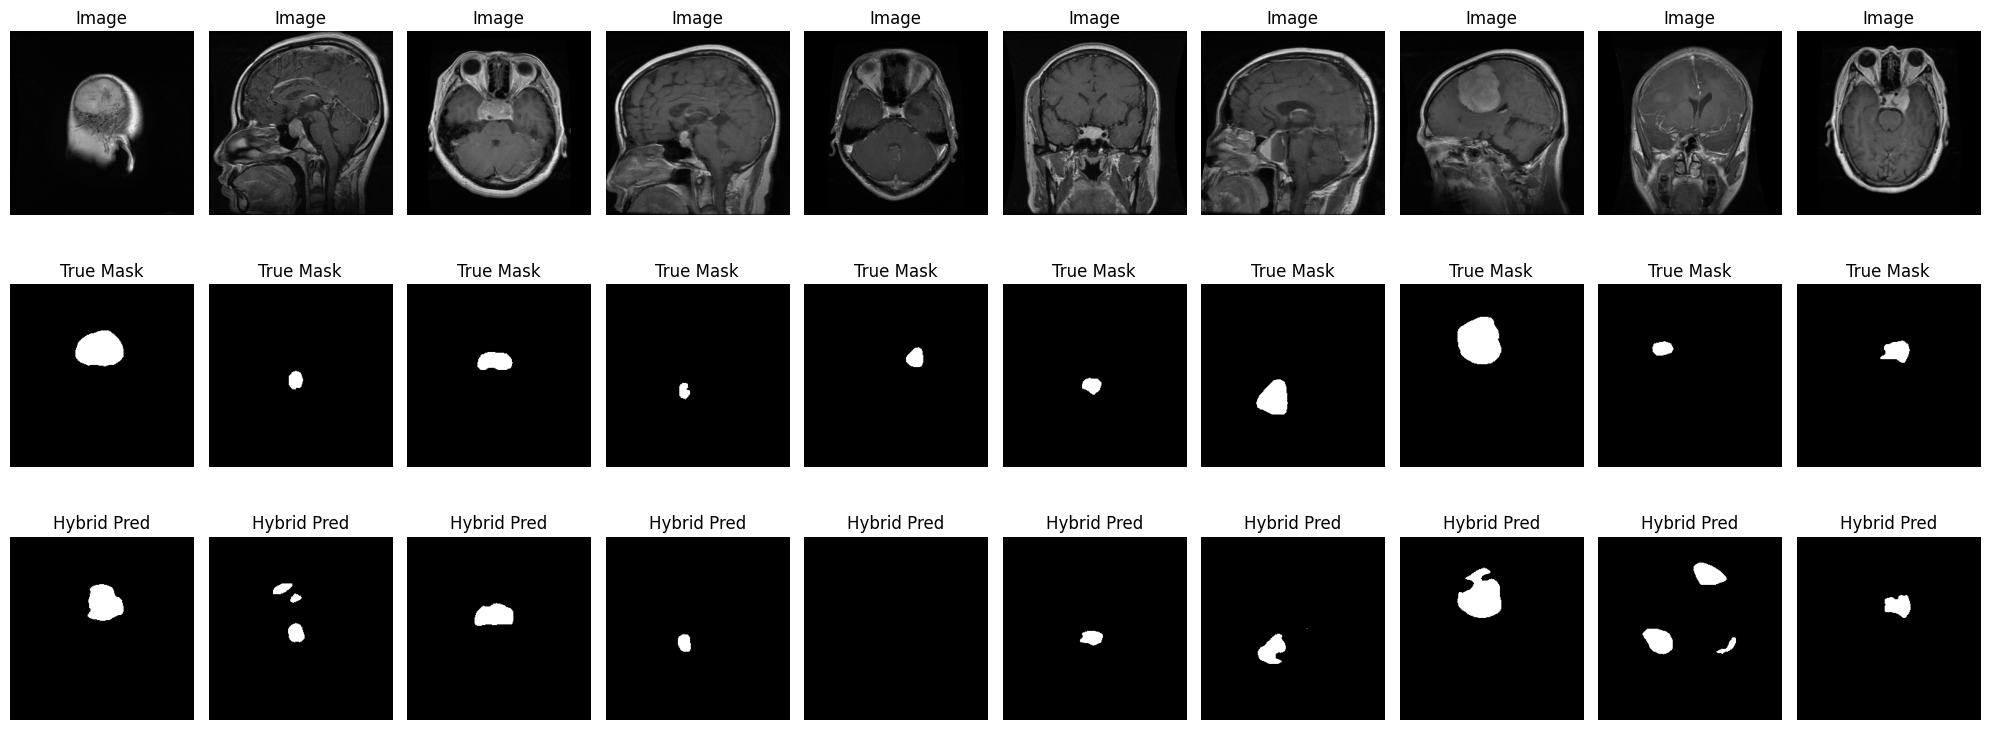

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Get 10 random indices from the test set
indices = random.sample(range(len(x_test)), 10)

# Predict and plot for each selected index
plt.figure(figsize=(20, 8))  # Adjust figure size for 10 images
for i, idx in enumerate(indices):
    # Get input image, true mask
    image = x_test[idx]
    true_mask = y_test[idx]

    # Get predicted mask from the hybrid model
    pred_mask = hybrid.predict(np.expand_dims(image, axis=0), verbose=0)[0]

    # Binarize the prediction
    pred_mask = (pred_mask > 0.5).astype(np.float32)

    # Plot
    plt.subplot(3, 10, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(3, 10, i + 1 + 10)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')

    plt.subplot(3, 10, i + 1 + 2 * 10)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title("Hybrid Pred")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print("Baseline CNN:",
      {k: v for k,v in baseline_eval.items() if k not in ["cm","fpr","tpr"]})
print("Hybrid CNN+Transformer:",
      {k: v for k,v in hybrid_eval.items() if k not in ["cm","fpr","tpr"]})

Baseline CNN: {'dice': np.float64(0.5590681832042527), 'sensitivity': np.float64(0.5176603126609447), 'specificity': np.float64(0.9941055233901873), 'auc': np.float64(0.9495405372749505)}
Hybrid CNN+Transformer: {'dice': np.float64(0.7243340566922611), 'sensitivity': np.float64(0.7293465858078249), 'specificity': np.float64(0.9949823395555595), 'auc': np.float64(0.9583490767859665)}


In [ ]:
import pandas as pd

# Create a dictionary for the results
results_data = {
    'Metric': ['Dice Coefficient', 'Sensitivity (TPR)', 'Specificity (TNR)', 'AUC'],
    'Baseline CNN': [baseline_eval['dice'], baseline_eval['sensitivity'], baseline_eval['specificity'], baseline_eval['auc']],
    'Hybrid CNN+Transformer': [hybrid_eval['dice'], hybrid_eval['sensitivity'], hybrid_eval['specificity'], hybrid_eval['auc']]
}

# Create a pandas DataFrame
results_df = pd.DataFrame(results_data)

# Display the DataFrame
display(results_df)

,Metric,Baseline CNN,Hybrid CNN+Transformer
0,Dice Coefficient,0.559068,0.724334
1,Sensitivity (TPR),0.517660,0.729347
2,Specificity (TNR),0.994106,0.994982
3,AUC,0.949541,0.958349


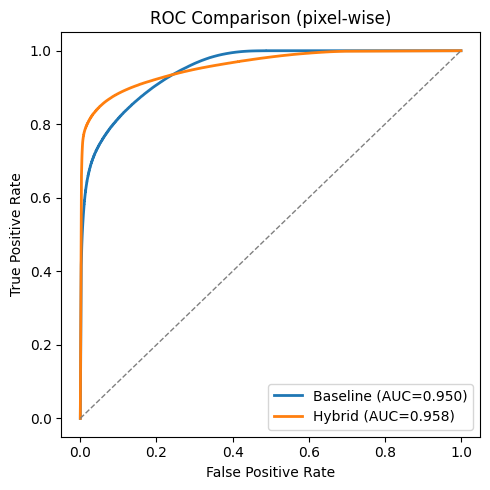

In [ ]:
# ---- Plot side-by-side ROC ----
plt.figure(figsize=(5,5))
plt.plot(baseline_eval["fpr"], baseline_eval["tpr"], lw=2, label=f"Baseline (AUC={baseline_eval['auc']:.3f})")
plt.plot(hybrid_eval["fpr"], hybrid_eval["tpr"], lw=2, label=f"Hybrid (AUC={hybrid_eval['auc']:.3f})")
plt.plot([0,1],[0,1],'--', color='gray', lw=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Comparison (pixel-wise)")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

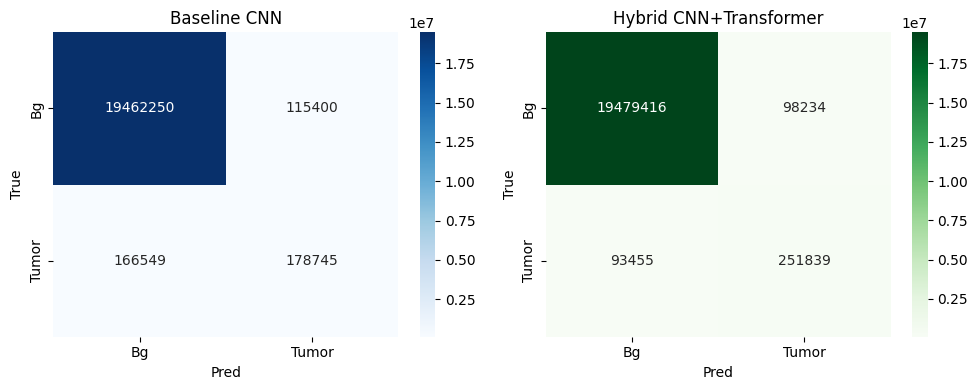

In [ ]:
# ---- Confusion matrices ----
fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(baseline_eval["cm"], annot=True, fmt="d", cmap="Blues",
            xticklabels=["Bg","Tumor"], yticklabels=["Bg","Tumor"], ax=ax[0])
ax[0].set_title("Baseline CNN"); ax[0].set_xlabel("Pred"); ax[0].set_ylabel("True")

sns.heatmap(hybrid_eval["cm"], annot=True, fmt="d", cmap="Greens",
            xticklabels=["Bg","Tumor"], yticklabels=["Bg","Tumor"], ax=ax[1])
ax[1].set_title("Hybrid CNN+Transformer"); ax[1].set_xlabel("Pred"); ax[1].set_ylabel("True")

plt.tight_layout(); plt.show()

### Quick Inference-Time Check

Avg inference per image (256x256): Baseline=73.1 ms | Hybrid=71.5 ms


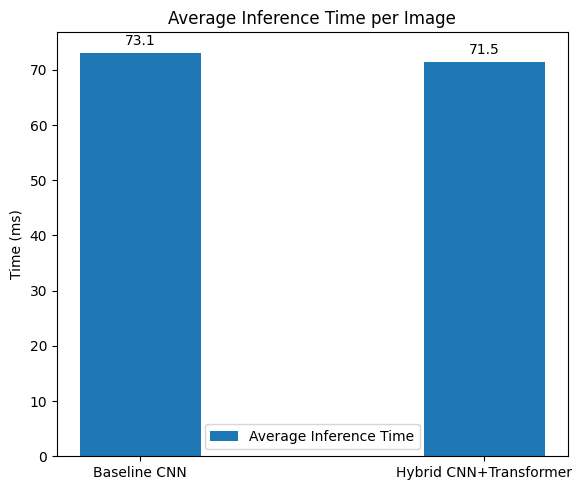

In [ ]:
import time
import matplotlib.pyplot as plt
import numpy as np

def average_inference_ms(model, x, reps=50):
    # warm-up
    _ = model.predict(x[:1], verbose=0)
    t0 = time.time()
    for _ in range(reps):
        _ = model.predict(x[:1], verbose=0)
    dt = time.time() - t0
    return (dt/reps)*1000.0

t_ms_base = average_inference_ms(model, x_test, reps=30)
t_ms_hyb  = average_inference_ms(hybrid, x_test, reps=30)

print(f"Avg inference per image (256x256): Baseline={t_ms_base:.1f} ms | Hybrid={t_ms_hyb:.1f} ms")

# Plotting the inference times
labels = ['Baseline CNN', 'Hybrid CNN+Transformer']
inference_times = [t_ms_base, t_ms_hyb]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(6, 5))
rects = ax.bar(x, inference_times, width, label='Average Inference Time')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (ms)')
ax.set_title('Average Inference Time per Image')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

fig.tight_layout()
plt.show()

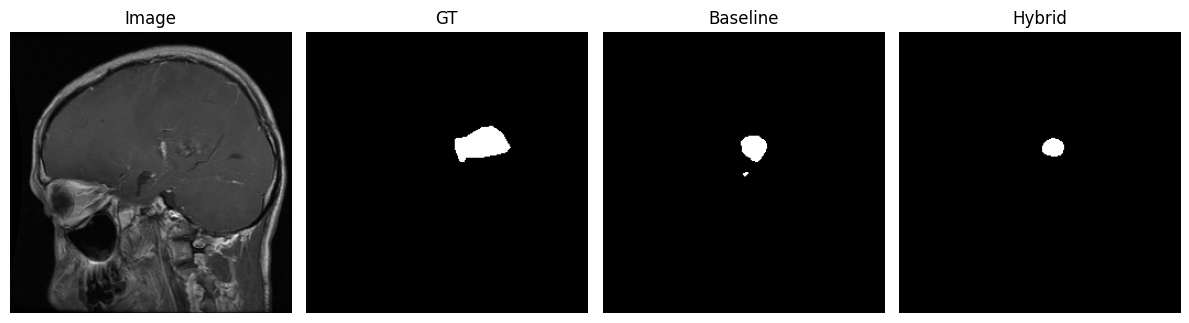

In [ ]:
def show_triplet(idx, model_a, model_b, name_a="Baseline", name_b="Hybrid", thr=0.5):
    img = x_test[idx:idx+1]
    gt  = y_test[idx]
    pa  = (model_a.predict(img, verbose=0)[0] > thr).astype(np.uint8)
    pb  = (model_b.predict(img, verbose=0)[0] > thr).astype(np.uint8)

    plt.figure(figsize=(12,4))
    plt.subplot(1,4,1); plt.title("Image"); plt.imshow(img[0].squeeze(), cmap="gray"); plt.axis("off")
    plt.subplot(1,4,2); plt.title("GT");    plt.imshow(gt.squeeze(), cmap="gray"); plt.axis("off")
    plt.subplot(1,4,3); plt.title(name_a);  plt.imshow(pa.squeeze(), cmap="gray"); plt.axis("off")
    plt.subplot(1,4,4); plt.title(name_b);  plt.imshow(pb.squeeze(), cmap="gray"); plt.axis("off")
    plt.tight_layout(); plt.show()

show_triplet(idx=0, model_a=model, model_b=hybrid)

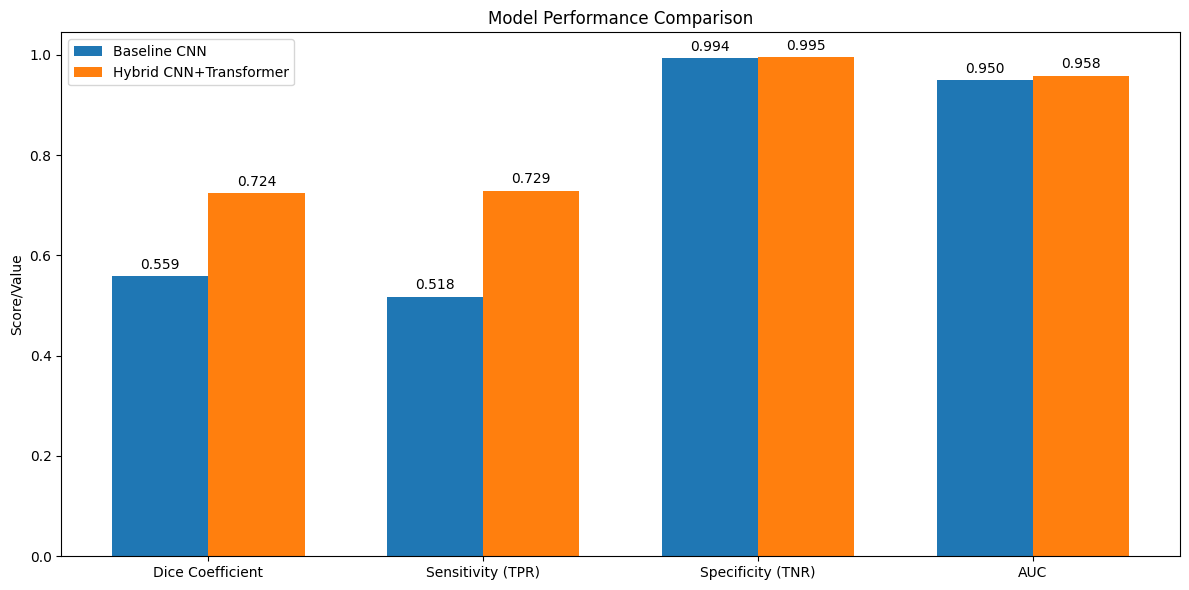

In [ ]:
results_data_with_loss = {
    'Metric': ['Dice Coefficient', 'Sensitivity (TPR)', 'Specificity (TNR)', 'AUC'],
    'Baseline CNN': [baseline_eval['dice'], baseline_eval['sensitivity'], baseline_eval['specificity'], baseline_eval['auc']],
    'Hybrid CNN+Transformer': [hybrid_eval['dice'], hybrid_eval['sensitivity'], hybrid_eval['specificity'], hybrid_eval['auc']]
}

results_df_with_loss = pd.DataFrame(results_data_with_loss)

# Plotting the bar chart
import matplotlib.pyplot as plt
import numpy as np

metrics = results_df_with_loss['Metric']
baseline_values = results_df_with_loss['Baseline CNN']
hybrid_values = results_df_with_loss['Hybrid CNN+Transformer']

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline CNN')
rects2 = ax.bar(x + width/2, hybrid_values, width, label='Hybrid CNN+Transformer')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Score/Value')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('%.3f' % height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

## Model Comparison

Based on the evaluation results, here's a comparison of the two models:

The Hybrid CNN+Transformer model shows a significant improvement in performance compared to the Baseline CNN model on the test set.

*   **Test Loss and Dice Coefficient:** The Hybrid model achieved a lower test loss (around 0.277) and a higher Test Dice Coefficient (around 0.723) compared to the Baseline CNN (test loss around 0.446 and Dice Coefficient around 0.552). A higher Dice Coefficient indicates better overlap between the predicted tumor mask and the true tumor mask.

*   **Sensitivity (TPR) and Specificity (TNR):** The Hybrid model also improved Sensitivity (True Positive Rate), meaning it was better at correctly identifying tumor pixels. Both models showed high Specificity (True Negative Rate), indicating they were good at correctly identifying non-tumor pixels.

*   **AUC (Area Under the ROC Curve):** The Hybrid model has a slightly higher AUC (around 0.958) than the Baseline CNN (around 0.950), suggesting a better overall trade-off between true positive rate and false positive rate across different thresholds.

*   **Inference Time:** Interestingly, the Hybrid model appears to have a slightly faster average inference time per image compared to the Baseline CNN, based on the quick check performed. This suggests that the added complexity of the Transformer layers, in this implementation, did not necessarily lead to a significant increase in inference time.

In summary, the integration of Transformer blocks into the U-Net architecture in the Hybrid model seems to have effectively captured long-range dependencies, leading to improved brain tumor segmentation performance on this dataset while maintaining competitive inference speed.